# Introduction

Hello, I'm **Wesley**, nice to meet you! 👋

I love the **Angry Birds** game! I used to play it day and night nonstop!

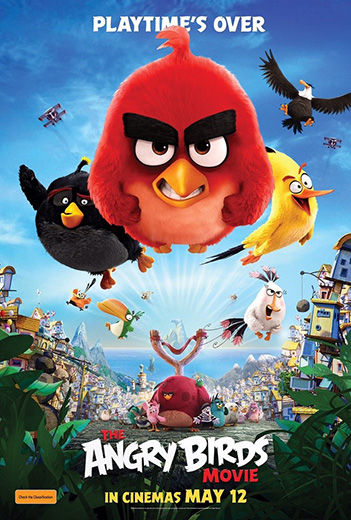

Let's make an **😡🐦 ANGRY BIRDS Classifier** to classify **ANGRY Tweets**!

We will be using the [Twitter Emotion Dataset](https://huggingface.co/datasets/tweet_eval) and [BERT](https://huggingface.co/docs/transformers/model_doc/bert) using [Transfer Learning](https://en.wikipedia.org/wiki/Transfer_learning) in native [PyTorch](https://en.wikipedia.org/wiki/PyTorch) to make the classifier.

# Setup Python Libraries with pip 🤫

In [1]:
%%bash
pip install numpy torch datasets transformers~=4.28.0 evaluate tqdm --quiet
pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate'

datasets==2.1.0
evaluate==0.4.0
numpy==1.23.5
torch @ file:///tmp/torch/torch-2.0.0-cp310-cp310-linux_x86_64.whl#sha256=3a7abcaa5ae70fd4eb83c2cc43abc8ba94995316c6433e171d7454f107d41b58
torchaudio @ file:///tmp/torch/torchaudio-2.0.1-cp310-cp310-linux_x86_64.whl#sha256=83e258b68459f1ff64301c19c2fc791a692fd372271abeef8414854aafd03b06
torchdata==0.6.0
torchinfo==1.8.0
torchmetrics==0.11.4
torchtext @ file:///tmp/torch/torchtext-0.15.1-cp310-cp310-linux_x86_64.whl#sha256=110ca71f44e505c040ea2f41dcaf798cd7de1b55cbedaa6687b9e21eec759844
torchvision @ file:///tmp/torch/torchvision-0.15.1-cp310-cp310-linux_x86_64.whl#sha256=3b0e4e01ab713c145b7e20684eb79f983e75c8c13034901f21e3e8a36a1b3292
transformers==4.28.1


# Create Angry Tweets Dataset for Training BERT

## Clone Twitter Emotion Dataset

In [2]:
from datasets import load_dataset

# let's clone the 'tweet_eval' dataset, specifically the 'emotion' sub-dataset with angry tweets
raw_datasets = load_dataset('tweet_eval', 'emotion')
raw_datasets

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3257 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1421 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/374 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/emotion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1421
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 374
    })
})

## Let's look at some example tweets

In [3]:
# let's print out 5 examples of tweets and their labels
for i in range(5):
    print(f"TEXT[{i}] : {raw_datasets['train']['text'][i]}")
    print(f"LABEL[{i}]: {'ANGRY' if raw_datasets['train']['label'][i] == 0 else 'NOT ANGRY'}")
    print('\n')

TEXT[0] : “Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry
LABEL[0]: NOT ANGRY


TEXT[1] : My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs
LABEL[1]: ANGRY


TEXT[2] : No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu
LABEL[2]: NOT ANGRY


TEXT[3] : Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight
LABEL[3]: ANGRY


TEXT[4] : it's pretty depressing when u hit pan on ur favourite highlighter
LABEL[4]: NOT ANGRY




# Setup Training BERT

## Let's tokenize the dataset

In [4]:
from transformers import AutoTokenizer

# let's get the fast bert tokenizer
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [5]:
# since the dataset already has train, validation, and test set
# let's immediately make a tokenized dataset

def tokenization(batch):
    tokenized_batch = tokenizer(batch['text'], truncation=True)
    # we set all 'ANGRY' text to label '1' and 'NOT ANGRY' to label '0'
    tokenized_batch['label'] = [1 if label==0 else 0 for label in batch['label']]
    return tokenized_batch

tokenized_datasets = raw_datasets.map(tokenization, batched=True, remove_columns=['text'])
tokenized_datasets = tokenized_datasets.rename_column('label', 'labels')
tokenized_datasets.set_format('torch')
tokenized_datasets

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1421
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 374
    })
})

In [6]:
# let's print out 5 tokenized tweets
for i in range(5):
    print(f"      RAW TEXT[{i}]: {raw_datasets['train']['text'][i]}")
    print(f"TOKENIZED TEXT[{i}]: {tokenized_datasets['train']['input_ids'][i]}")
    print(f"        LABELS[{i}]: {'ANGRY' if tokenized_datasets['train']['labels'][i] == 1 else 'NOT ANGRY'}")
    print('\n')

      RAW TEXT[0]: “Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry
TOKENIZED TEXT[0]: tensor([  101,  1523,  4737,  2003,  1037,  2091,  7909,  2006,  1037,  3291,
         2017,  2089,  2196,  2031,  1005,  1012, 11830, 11527,  1012,  1001,
        14354,  1001,  4105,  1001,  4737,   102])
        LABELS[0]: NOT ANGRY


      RAW TEXT[1]: My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs
TOKENIZED TEXT[1]: tensor([  101,  2026, 18328,  1024,  2009,  1005,  1055,  3100,  2008,  2057,
         2064,  1005,  1056,  6297,  2138,  2057,  2031,  8285, 27108,  2890,
         6593,  1012,  1001,  6659,  1001,  2034, 11108, 21572,  5910,   102])
        LABELS[1]: ANGRY


      RAW TEXT[2]: No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu
TOKENIZED TEXT[2]: tensor([  101,  2053,  2021,  2008,  1005,  1055,  2061, 10140,  1012,  2012,
         

## Let's setup the Dataloaders for training in PyTorch

### Set PyTorch Constants

In [7]:
import torch

# set seed to 42 for reproducibility
torch.manual_seed(42)

# get device to move model and data
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(f"DEVICE: {device.type}")

DEVICE: cuda


### Setup a data collator for dynamic batch padding

In [8]:
from transformers import DataCollatorWithPadding

# let's get data collator for dynamic padding per batch with the tokenizer
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

### Setup Dataloaders

In [9]:
from torch.utils.data import DataLoader

# we shuffle the training dataset every epoch
train_dataloader = DataLoader(
    tokenized_datasets['train'],
    batch_size=16,
    shuffle=True,
    collate_fn=data_collator,
)

validation_dataloader = DataLoader(
    tokenized_datasets['validation'],
    batch_size=16,
    collate_fn=data_collator,
)

test_dataloader = DataLoader(
    tokenized_datasets['test'],
    batch_size=16,
    collate_fn=data_collator,
)

## Let's clone BERT model

In [10]:
from transformers import AutoModelForSequenceClassification

checkpoint = 'distilbert-base-uncased'
num_labels = 2
id2label = {0:'NOT ANGRY',1:'ANGRY'}
label2id = {'NOT ANGRY':0,'ANGRY':1}

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id)

# move model to gpu if not cpu
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

## Let's setup the Optimizer and Scheduler

In [11]:
from transformers import AdamW, get_scheduler

# get an optimizer with a smaller learning rate (default=1e-3)
optimizer = AdamW(model.parameters(), lr=1e-5, no_deprecation_warning=True)

# make a linear scheduler with no warmup
scheduler_name = 'linear'
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
num_warmup_steps = 0
lr_scheduler = get_scheduler(
    name=scheduler_name,
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)

print(f"NUMBER OF TRAINING STEPS: {num_training_steps}")

NUMBER OF TRAINING STEPS: 612


# Train BERT by Fine-Tuning

In [12]:
from tqdm.auto import tqdm
import evaluate

## Let's see what a UnFine-Tune BERT can do

In [13]:
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')
test_progress_bar = tqdm(range(len(test_dataloader)))

model.eval()
for batch in test_dataloader:
    batch = {k:v.to(device) for k,v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
        
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    accuracy_metric.add_batch(predictions=predictions, references=batch['labels'])
    f1_metric.add_batch(predictions=predictions, references=batch['labels'])
    
    test_progress_bar.update(1)
    
print(f"TEST ACCURACY: {accuracy_metric.compute()['accuracy']}; TEST F1: {f1_metric.compute()['f1']}")

  0%|          | 0/89 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TEST ACCURACY: 0.6052076002814919; TEST F1: 0.0


Without fine-tuning BERT, our model currently has around **60% Accuracy** and **0% F1**, which is quite bad. 😕

Let's make it better with transfer learning! 🦾

## Fine-Tune BERT

In [14]:
train_progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    print(f"EPOCH {epoch+1}:", end=" ")
    
    # let's train the model
    training_loss = 0.0
    accuracy_metric = evaluate.load('accuracy')
    f1_metric = evaluate.load('f1')
    
    model.train()
    for batch in train_dataloader:
        batch = {k:v.to(device) for k,v in batch.items()}
        
        optimizer.zero_grad()
        
        outputs = model(**batch)
        loss = outputs.loss
        
        training_loss += loss.item()
        predictions = torch.argmax(outputs.logits, dim=-1)
        accuracy_metric.add_batch(predictions=predictions, references=batch['labels'])
        f1_metric.add_batch(predictions=predictions, references=batch['labels'])
        
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        train_progress_bar.update(1)
        
    training_loss /= len(train_dataloader)
    print(f"TRAINING LOSS: {training_loss:.5f}; TRAINING ACCURACY: {accuracy_metric.compute()['accuracy']:.5f}; TRAINING F1: {f1_metric.compute()['f1']:.5f}", end="; ")

    # let's evaluate the model
    validation_loss = 0.0
    accuracy_metric = evaluate.load('accuracy')
    f1_metric = evaluate.load('f1')
    
    model.eval()
    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k:v.to(device) for k,v in batch.items()}
            outputs = model(**batch)
            
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            
            validation_loss += outputs.loss.item()
            accuracy_metric.add_batch(predictions=predictions, references=batch['labels'])
            f1_metric.add_batch(predictions=predictions, references=batch['labels'])

    validation_loss /= len(test_dataloader)
    
    print(f"VALIDATION LOSS: {validation_loss:.5f}; VALIDATION ACCURACY: {accuracy_metric.compute()['accuracy']:.5f}; VALIDATION F1: {f1_metric.compute()['f1']:.5f}")

  0%|          | 0/612 [00:00<?, ?it/s]

EPOCH 1: TRAINING LOSS: 0.50013; TRAINING ACCURACY: 0.74977; TRAINING F1: 0.64946; VALIDATION LOSS: 0.31311; VALIDATION ACCURACY: 0.87051; VALIDATION F1: 0.82963
EPOCH 2: TRAINING LOSS: 0.27126; TRAINING ACCURACY: 0.89530; TRAINING F1: 0.87559; VALIDATION LOSS: 0.29599; VALIDATION ACCURACY: 0.87966; VALIDATION F1: 0.84800
EPOCH 3: TRAINING LOSS: 0.20688; TRAINING ACCURACY: 0.92908; TRAINING F1: 0.91633; VALIDATION LOSS: 0.29835; VALIDATION ACCURACY: 0.88248; VALIDATION F1: 0.85286


## Let's see what a Fine-Tuned BERT can do

In [15]:
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')
test_progress_bar = tqdm(range(len(test_dataloader)))

model.eval()
for batch in test_dataloader:
    batch = {k:v.to(device) for k,v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
        
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    accuracy_metric.add_batch(predictions=predictions, references=batch['labels'])
    f1_metric.add_batch(predictions=predictions, references=batch['labels'])
    
    test_progress_bar.update(1)
    
print(f"TEST ACCURACY: {accuracy_metric.compute()['accuracy']}; TEST F1: {f1_metric.compute()['f1']}")

  0%|          | 0/89 [00:00<?, ?it/s]

TEST ACCURACY: 0.8824771287825475; TEST F1: 0.852863436123348


Woah! We got a **88% Accuracy** and **85% F1** in **1 minute**! 🤯

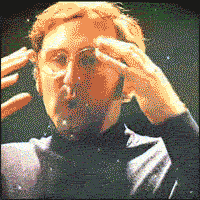

# Let's try out some examples!

In [21]:
from transformers import pipeline

# we setup a angry birds classifier with our custom model and tokenizer 
angry_birds_classifier = pipeline(task='text-classification', model=model, tokenizer=tokenizer, device=torch.cuda.current_device())

In [22]:
# let's try a angry message

tweet = """
I hate you!
"""

angry_birds_classifier(tweet)

[{'label': 'ANGRY', 'score': 0.9772096276283264}]

**97% ANGRY! That's correct!**

In [23]:
# let's try a loving message

tweet = """
I love you!
"""

angry_birds_classifier(tweet)

[{'label': 'NOT ANGRY', 'score': 0.9717423915863037}]

**97% NOT ANGRY! That's correct!**